In [1]:
## os library for computer path
import os.path

## numpy library
import numpy as np

## jax library for autodiff
import jax
## enable x64
jax.config.update("jax_enable_x64", True)
import jax.numpy as np
## jax-cosmo library - main driver for producing observables and fisher forecasts
import jax_cosmo as jc
## CCL library - DES official library, serves a cross-check of the Fisher matrix stability in jax-cosmo
import pyccl as ccl

## astropy module to handle fits file
from astropy.io import fits

## matplotlib library
import matplotlib
from matplotlib.ticker import MultipleLocator, FormatStrFormatter # for tick format
from matplotlib import cm # for colormaps
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
## personal preference for matplotlib fonts
plt.rcParams.update({
    #"text.usetex": True,
    #"font.family": "sans-serif",
    #"font.sans-serif": "Computer Modern",
    "font.size": 22})

# First, we check the implementation of f(z) and D(z) in `jax-cosmo`.

### Define cosmology and utility functions

In [2]:
cosmo_param_nr = 9

In [3]:
#Error bar graph doesn't work right now, need to fix.
def plot_1d_error(cov, names, inds: list, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    
    #verify that names and inds are of the same length
    assert len(names)==len(inds)

    ax.barh(names, np.sqrt(cov[inds, inds]), **kwargs)

    

def get_params_vec(cosmo):
#def get_params_vec(cosmo, b_l, dz_l):
    """
    Packs cosmological and DES source and lens systematic parameters
    into a single 1D parameter vector (stored in a numpy array)
    """
    return np.array([ 
        # Cosmological parameters [Omega_m, Omega_b, h, S8, ns, gamma, w0, wa] 
        #cosmo.Omega_k,
        cosmo.Omega_m, cosmo.Omega_b,
        cosmo.h, cosmo.n_s, cosmo.S8,
        cosmo.w0, cosmo.wa,
        cosmo.gamma0, cosmo.gamma1
    ])

def unpack_params_vec(params):
    """
    Unpacks a 1D parameter vector (stored in a numpy array)
    into cosmological and DES source and lens systematic parameters
    """
    # Retrieve cosmology
    cosmo = params[0:cosmo_param_nr]
    return cosmo
    #return cosmo, [b1,b2,b3,b4,b5], [dz1_l,dz2_l,dz3_l,dz4_l,dz5_l]

In [4]:
PL18_h=0.6732
PL18_omegac=0.12011/(PL18_h**2)
PL18_omegab=0.022383/(PL18_h**2) # won't vary in this example
PL18_sigma8=0.812
PL18_ns=0.96605
## Baseline PL18 assumes LCDM, hence omegak=0, w0=-1,wa=0. Here we specify but won't vary them in the forecasts
PL18_omegak=0.0
PL18_w0=-1.0
PL18_wa=0.0
## Gamma Extension
## After cross-check the jax-cosmo Fisher contours with the counterparts from CCL, we can include gamma.
## The reason not to include gamma in the comparison against CCL is because gamma is not available in CCL
GR_gamma0=0.55
GR_gamma1=0.


fid_cosmo = jc.Cosmology(Omega_m=PL18_omegac+PL18_omegab,
                         Omega_c=PL18_omegac,
                         Omega_b=PL18_omegab,
                         h=PL18_h,
                         n_s=PL18_ns,
                         sigma8=PL18_sigma8,
                         S8=PL18_sigma8*((PL18_omegac+PL18_omegab)/0.3)**0.5,
                         Omega_k=PL18_omegak,w0=PL18_w0,wa=PL18_wa, gamma0=GR_gamma0, gamma1=GR_gamma1)

fid_params = get_params_vec(fid_cosmo)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## fsigma8(z)

First, we check the implementation of $f\sigma_8(z)$ in `jax-cosmo` against several $f\sigma_8$ measurements from various sources, summarized in [arXiv:2304.07281v2](https://arxiv.org/abs/2304.07281) Table 2.

In [5]:
from jax_cosmo.background import growth_rate, growth_factor
from jax_cosmo.utils import z2a

def fsigma8(cosmo, z):
    a = z2a(z)
    return growth_rate(cosmo, a)*growth_factor(cosmo, a)*cosmo.sigma8

Text(0, 0.5, 'f\\sigma_8')

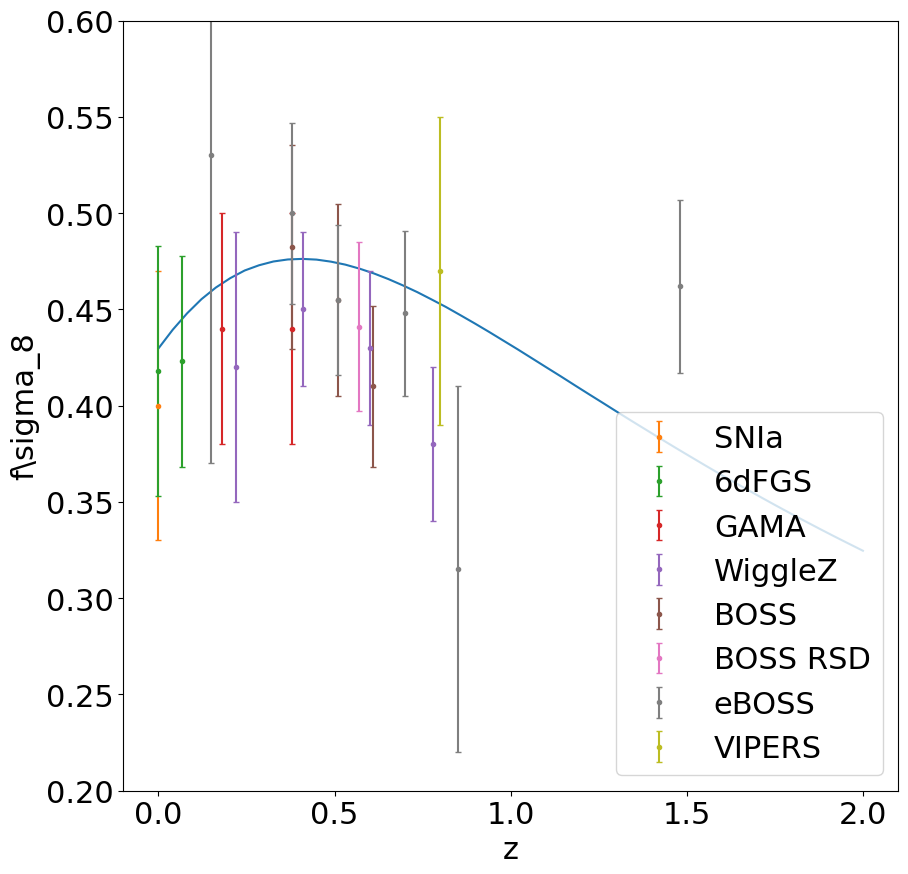

In [6]:
zs = np.linspace(0,2)


plt.figure(figsize=(10,10))
plt.plot(zs, fsigma8(fid_cosmo, zs))
plt.errorbar([0],[.4], yerr=[.07], label='SNIa', ls='none', marker='.', capsize=2)
plt.errorbar([0,.067],[.418,.423], yerr=[.065,.055], label='6dFGS', ls='none', marker='.', capsize=2)
plt.errorbar([.18, .38],[.44, .44], yerr=[.06,.06], label='GAMA', ls='none', marker='.', capsize=2)
plt.errorbar([.22, .41, .6, .78], [.42, .45, .43, .38], yerr=[.07,.04,.04,.04], label='WiggleZ', ls='none', marker='.', capsize=2)
plt.errorbar([.38, .51, .61], [.4823, .455, .41], yerr=[.053,.05,.042], label='BOSS', ls='none', marker='.', capsize=2)
plt.errorbar([.57], [.441], yerr=[.044], label="BOSS RSD", ls='none', marker='.', capsize=2)
plt.errorbar([.15, .38, .51, .7, .85, 1.48], [.53, .5, .455, .448, .315, .462], yerr=[.16,.047,.039,.043,.095,.045], label='eBOSS', ls='none', marker='.', capsize=2)
plt.errorbar([.8],[.47], yerr=[.08], label='VIPERS', ls='none', marker='.', capsize=2)
plt.ylim((.2,.6))
plt.legend(loc='lower right')

plt.xlabel('z')
plt.ylabel(r'f\sigma_8')

In [7]:
z = np.linspace(0, 5, num=10)

In [8]:
def compute_fsigma8_mean(params):
    cosmo_params = unpack_params_vec(params)
    cosmo = jc.Cosmology(Omega_m=cosmo_params[0],
                         Omega_c=cosmo_params[0]-cosmo_params[1],
                         Omega_b=cosmo_params[1],
                         Omega_k=PL18_omegak,
                         h=cosmo_params[2],
                         n_s=cosmo_params[3],
                         S8=cosmo_params[4], sigma8=cosmo_params[4]/(cosmo_params[0]/0.3)**0.5,
                         w0=cosmo_params[5], wa = cosmo_params[6],
                         gamma0=cosmo_params[7], gamma1=cosmo_params[8])
    fsigma8s = fsigma8(cosmo, z)
    return fsigma8s

In [9]:
means = compute_fsigma8_mean(fid_params)

In [10]:
compute_fsigma8_jac = jax.jit(jax.jacfwd(compute_fsigma8_mean))

In [11]:
jacobian = compute_fsigma8_jac(fid_params)
print(jacobian)

[[ 6.83358564e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   5.16934947e-01 -6.70898341e-18  5.59081951e-19 -4.97199993e-01
  -7.92032764e-19]
 [-4.90262084e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   5.67917492e-01 -1.01328445e-01 -2.09728162e-02 -1.12950921e-01
  -3.69514366e-02]
 [-6.99577937e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   5.03826163e-01 -4.73621437e-02 -1.90689797e-02  3.78356398e-02
  -3.38959057e-02]
 [-7.01504321e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.29405362e-01 -1.81826700e-03 -8.36119220e-03  7.95972282e-02
  -1.67105510e-02]
 [-6.44387016e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.67527339e-01  2.11335462e-02 -4.68764249e-04  8.67022242e-02
  -3.42464573e-03]
 [-5.79479676e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.18948377e-01  3.12081541e-02  4.12883071e-03  8.35499275e-02
   4.86027355e-03]
 [-5.20332906e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.80775292e-01  3.4969706

## $D_A(z)/r_s$

Next, we examine the `jax-cosmo` implementation of the angular diameter distance $D_A(z)$ and $r_s$ (sometimes referred to as $r_\mathrm{drag}$), the sound horizon at drag epoch by comparing the BAO quantity $D_A(z)/r_s$ to results from DESI.

In [12]:
def DA_rs(cosmo, z):
    a = z2a(z)
    D_A = jc.background.angular_diameter_distance(cosmo, a)
    r_s = jc.transfer.sh_d_Eisenstein_Hu(cosmo)
    return D_A/r_s

In [13]:
def compute_BAO_mean(params, z=z):
    cosmo_params = unpack_params_vec(params)
    cosmo = jc.Cosmology(Omega_m=cosmo_params[0],
                         Omega_c=cosmo_params[0]-cosmo_params[1],
                         Omega_b=cosmo_params[1],
                         Omega_k=PL18_omegak,
                         h=cosmo_params[2],
                         n_s=cosmo_params[3],
                         S8=cosmo_params[4], sigma8=cosmo_params[4]/(cosmo_params[0]/0.3)**0.5,
                         w0=cosmo_params[5], wa = cosmo_params[6],
                         gamma0=cosmo_params[7], gamma1=cosmo_params[8])
    BAOs = DA_rs(cosmo, z)
    return BAOs

In [14]:
means = compute_BAO_mean(fid_params)

In [15]:
compute_BAO_jac = jax.jit(jax.jacfwd(compute_BAO_mean))

In [16]:
BAO_jac = compute_BAO_jac(fid_params)
print(BAO_jac)

[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 4.14879991 24.29408899 -2.90557858  0.          0.         -1.45561987
  -0.1843147   0.          0.        ]
 [ 2.42755112 30.75784485 -3.67864526  0.          0.         -2.20512989
  -0.4119615   0.          0.        ]
 [ 0.73087076 31.74164885 -3.79630844  0.          0.         -2.24993197
  -0.49136748  0.          0.        ]
 [-0.38733986 30.88582218 -3.69395137  0.          0.         -2.08544115
  -0.49276302  0.          0.        ]
 [-1.07746154 29.42859477 -3.51966664  0.          0.         -1.88516805
  -0.4658087   0.          0.        ]
 [-1.49840723 27.82951504 -3.32841634  0.          0.         -1.69815344
  -0.43126267  0.          0.        ]
 [-1.75284887 26.2637838  -3.14115453  0.          0.         -1.53525158
  -0.3968874   0.          0.        ]
 [-1.90296697 24.79574141 -2.96557633  0.          0.         -1.39613057
  -0.36529835  0.          0. 

Compute the Fisher matrix from DESI BAO constraint forecasts. Fractional errors are taken from [arXiv:1611.00036v2](https://arxiv.org/abs/1611.00036) Table 2.3

In [17]:
DESI_BAO_z = np.linspace(.65,1.85,num=13, endpoint=True)
print(DESI_BAO_z)
DESI_BAO_err_frac = np.array([.82,.69,.69,.73,.89,.94,.96,1.5,
                         1.59,1.9,2.88,4.64,4.71])
DESI_BAO_err_frac = DESI_BAO_err_frac/100

means = compute_BAO_mean(fid_params, z=DESI_BAO_z)
jacobian = compute_BAO_jac(fid_params, z=DESI_BAO_z)
print(jacobian)

[0.65 0.75 0.85 0.95 1.05 1.15 1.25 1.35 1.45 1.55 1.65 1.75 1.85]


[[ 3.96254669 26.10537496 -3.1222088   0.          0.         -1.66579342
  -0.23325506  0.          0.        ]
 [ 3.68337853 27.62448482 -3.30389468  0.          0.         -1.84631831
  -0.2816141   0.          0.        ]
 [ 3.35508618 28.81120918 -3.44582719  0.          0.         -1.98728911
  -0.32504292  0.          0.        ]
 [ 3.00288647 29.72802058 -3.55547804  0.          0.         -2.09361223
  -0.36289342  0.          0.        ]
 [ 2.64444077 30.42399772 -3.63871706  0.          0.         -2.17048509
  -0.39503609  0.          0.        ]
 [ 2.29175301 30.93823245 -3.70021966  0.          0.         -2.22292189
  -0.42170003  0.          0.        ]
 [ 1.95180692 31.30354375 -3.74391097  0.          0.         -2.25540787
  -0.44335141  0.          0.        ]
 [ 1.62661224 31.55014486 -3.77340452  0.          0.         -2.27153659
  -0.46054368  0.          0.        ]
 [ 1.32266265 31.69286465 -3.79047384  0.          0.         -2.27496244
  -0.47376565  0.     

In [18]:
cov_mat = np.diag(DESI_BAO_err_frac*means)
prc_mat = np.linalg.inv(cov_mat)

In [19]:
fisher = jacobian.T @ prc_mat @ jacobian
print(fisher.shape)

(9, 9)
